# In-Context Learning vs Fine-Tuning (ICL vs FT)

Comparative analysis on NLP tasks using Hugging Face and Ollama.

In [1]:
import ollama
import time
import pandas as pd
from transformers import pipeline
from prompts import build_prompt
from utils import (
    compute_f1, compute_em, compute_rouge,
    compute_bleu, compute_bertscore, compute_chrf,
    compute_classification_metrics
)
from evaluate import load
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


C:\Users\arunr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 🔧 Task Configuration

In [2]:
# Choose task manually
task = "Question Answering (SQuAD)"  # or "Text Classification (AG News)", "Translation (WMT)"
context = "Python is a programming language used in AI and web development."
question = "What is Python?"
expected = "a programming language"
prompt_style = "Few-Shot"


## 🤖 Fine-Tuned Model (BERT) Inference

In [3]:
results = []

if task == "Question Answering (SQuAD)":
    qa = pipeline("question-answering", model="deepset/bert-base-cased-squad2")
    ft_answer = qa(question=question, context=context)["answer"]
    print("Fine-Tuned Answer:", ft_answer)

    results.extend([
        {"Method": "FT-BERT", "Metric": "F1", "Score": compute_f1(ft_answer, expected)},
        {"Method": "FT-BERT", "Metric": "Exact Match", "Score": compute_em(ft_answer, expected)},
        {"Method": "FT-BERT", "Metric": "ROUGE-L", "Score": compute_rouge(ft_answer, expected)}
    ])
elif task == "Text Classification (AG News)":
    clf = pipeline("text-classification", model="textattack/bert-base-uncased-ag-news")
    ft_answer = clf(context)[0]["label"].lower()
    expected = expected.lower()
    print("Fine-Tuned Answer:", ft_answer)
    results.extend([
        {"Method": "FT-BERT", "Metric": k, "Score": v}
        for k, v in compute_classification_metrics(ft_answer, expected).items()
    ])
elif task == "Translation (WMT)":
    translator = pipeline("translation_en_to_fr", model="Helsinki-NLP/opus-mt-en-fr")
    ft_answer = translator(context)[0]["translation_text"]
    print("Fine-Tuned Translation:", ft_answer)
    results.extend([
        {"Method": "FT-BERT", "Metric": "BLEU", "Score": compute_bleu(ft_answer, expected)},
        {"Method": "FT-BERT", "Metric": "BERTScore", "Score": compute_bertscore(ft_answer, expected)},
        {"Method": "FT-BERT", "Metric": "ChrF", "Score": compute_chrf(ft_answer, expected)}
    ])


Some weights of the model checkpoint at deepset/bert-base-cased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Fine-Tuned Answer: a programming language


## 🧠 In-Context Learning (ICL) - LLaMA3 and DeepSeek

In [4]:
for model in ["llama3", "deepseek-r1"]:
    prompt = build_prompt(context, question, prompt_style, task)
    start = time.time()
    res = ollama.chat(model=model, messages=[{"role": "user", "content": prompt}])
    end = time.time()
    icl_answer = res["message"]["content"].strip()
    print(f"ICL {model} Answer: ({round(end-start, 2)}s)", icl_answer)

    if task == "Question Answering (SQuAD)":
        results.extend([
            {"Method": f"ICL-{model}", "Metric": "F1", "Score": compute_f1(icl_answer, expected)},
            {"Method": f"ICL-{model}", "Metric": "Exact Match", "Score": compute_em(icl_answer, expected)},
            {"Method": f"ICL-{model}", "Metric": "ROUGE-L", "Score": compute_rouge(icl_answer, expected)}
        ])
    elif task == "Text Classification (AG News)":
        icl_answer = icl_answer.lower().strip()
        expected = expected.lower().strip()
        results.extend([
            {"Method": f"ICL-{model}", "Metric": k, "Score": v}
            for k, v in compute_classification_metrics(icl_answer, expected).items()
        ])
    elif task == "Translation (WMT)":
        results.extend([
            {"Method": f"ICL-{model}", "Metric": "BLEU", "Score": compute_bleu(icl_answer, expected)},
            {"Method": f"ICL-{model}", "Metric": "BERTScore", "Score": compute_bertscore(icl_answer, expected)},
            {"Method": f"ICL-{model}", "Metric": "ChrF", "Score": compute_chrf(icl_answer, expected)}
        ])


ICL llama3 Answer: (14.09s) A programming language.
ICL deepseek-r1 Answer: (88.97s) <think>
Okay, so I need to figure out what Python is. The context given says that Python is a programming language used in AI and web development. Hmm, let me break this down step by step. 

First, the question is asking for an explanation of Python based solely on the provided context. So I shouldn't add any extra information beyond what's given. The context mentions two main areas where Python is used: AI (Artificial Intelligence) and web development.

Python being a programming language implies it's a tool that developers use to write software applications. In web development, Python can be used for things like building websites or web services. For example, frameworks like Django or Flask are built with Python, which helps in creating full-stack web applications where both the front-end and back-end are handled.

In AI, Python is also widely used. Libraries like TensorFlow and PyTorch make it easie

## 📊 Metric Comparison

Metric,Exact Match,F1,ROUGE-L
Method,,,
FT-BERT,100.0,100.000000,100.000000
ICL-deepseek-r1,0.0,1.212121,1.666667
ICL-llama3,100.0,100.000000,100.000000


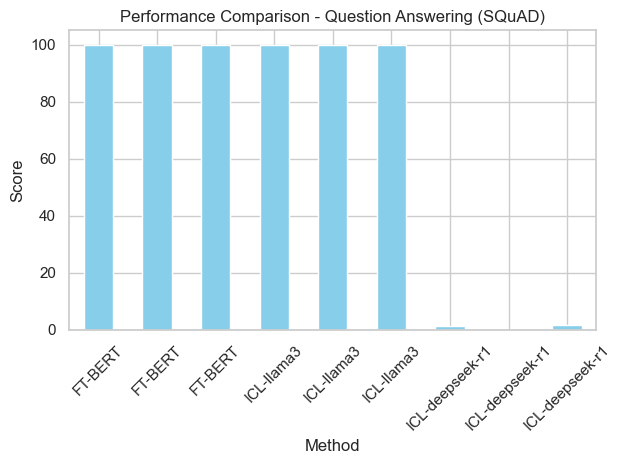

In [5]:
df = pd.DataFrame(results)
df_pivot = df.pivot(index='Method', columns='Metric', values='Score')
display(df_pivot)

df.plot(kind='bar', x='Method', y='Score', color='skyblue', legend=False)
plt.title(f"Performance Comparison - {task}")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
